
OBJECTIVE: Use satellite data to track the human footprint in the Amazon rainforest

Source: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [2]:
# Load csv.
df_train = pd.read_csv('C:/Users/4769939/Downloads/archive/planet/planet/train_classes.csv')
df_train.sample(5)

,image_name,tags
17187,train_17187,clear primary
14377,train_14377,clear primary
35064,train_35064,clear primary
12378,train_12378,agriculture haze primary
2046,train_2046,clear primary water


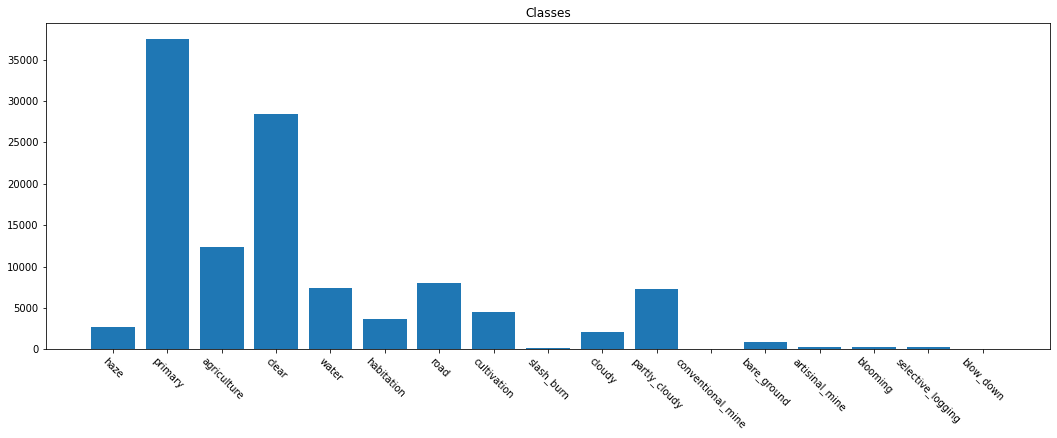

In [3]:
# Total number of tags and their names.
counts = {}
splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

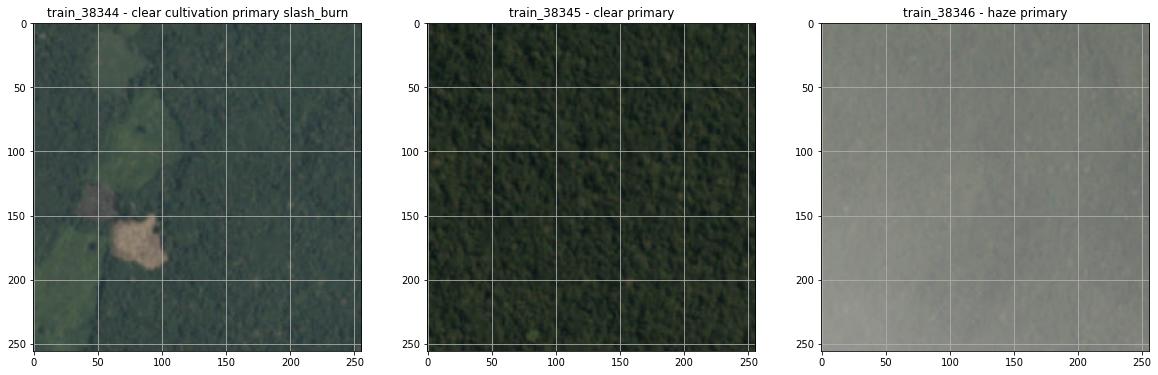

In [4]:
# Let's take a look at some random images.
plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0,len(df_train) - 3)
for i , (file, label) in enumerate(df_train[random_img:random_img + 3].values):
    img = cv2.imread('C:/Users/4769939/Downloads/archive/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [5]:
# Load data.
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(df_train, labels, resize):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in df_train.values:
        img = cv2.imread('C:/Users/4769939/Downloads/archive/planet/planet/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.

    return X_train, y_train

In [6]:
X, y = load_data(df_train, labels, resize=(128, 128))

In [7]:
# Split the dataset into training and validation.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = int(time.time()))

# Learning Curve

In [8]:
# Defining a function to plot our learning curve.
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F beta Score - Metric

In [9]:
# Fucntion to calculate the F Beta Score.
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

# CNN

In [11]:
# This will be our basline model.
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [12]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 119s 4ms/step - loss: 0.2496 - fbeta_score_K: 0.5807 - val_loss: 0.2232 - val_fbeta_score_K: 0.6222
Epoch 2/5
32383/32383 [==============================] - 108s 3ms/step - loss: 0.1946 - fbeta_score_K: 0.6561 - val_loss: 0.1770 - val_fbeta_score_K: 0.6840
Epoch 3/5
32383/32383 [==============================] - 107s 3ms/step - loss: 0.1735 - fbeta_score_K: 0.6961 - val_loss: 0.1740 - val_fbeta_score_K: 0.7053
Epoch 4/5
32383/32383 [==============================] - 106s 3ms/step - loss: 0.1615 - fbeta_score_K: 0.7181 - val_loss: 0.1597 - val_fbeta_score_K: 0.7174
Epoch 5/5
32383/32383 [==============================] - 106s 3ms/step - loss: 0.1556 - fbeta_score_K: 0.7283 - val_loss: 0.1546 - val_fbeta_score_K: 0.7273


In [13]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100 - score * 100))

F beta score:  0.8506458157912676
Error: 14.94%


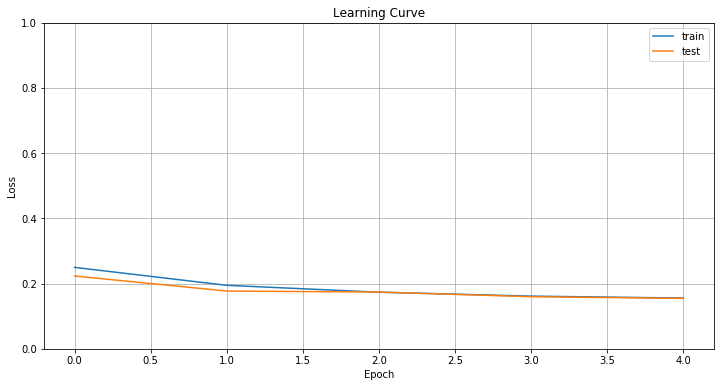

In [14]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

# VGG-16

In [10]:
optimizer = Adam(0.003, decay=0.0005)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
    base_model,
 
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 8192)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 17)                2193      
                                                                 
Total params: 15,765,585
Trainable params: 1,050,897
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 147s 5ms/step - loss: 0.1876 - fbeta_score_K: 0.6884 - val_loss: 0.1497 - val_fbeta_score_K: 0.7217
Epoch 2/5
32383/32383 [==============================] - 146s 4ms/step - loss: 0.1503 - fbeta_score_K: 0.7371 - val_loss: 0.1407 - val_fbeta_score_K: 0.7488
Epoch 3/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1418 - fbeta_score_K: 0.7523 - val_loss: 0.1362 - val_fbeta_score_K: 0.7632
Epoch 4/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1375 - fbeta_score_K: 0.7600 - val_loss: 0.1410 - val_fbeta_score_K: 0.7767
Epoch 5/5
32383/32383 [==============================] - 146s 5ms/step - loss: 0.1336 - fbeta_score_K: 0.7667 - val_loss: 0.1309 - val_fbeta_score_K: 0.7738


In [17]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.8814680564589861
Error: 11.85%


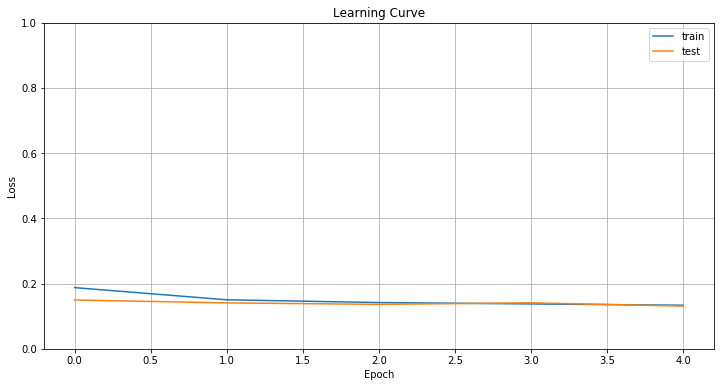

In [18]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

## Using Image Generator for Data Augmentation to see if VGG-16 performance improves.

In [11]:
# Let's use fit generator to augment our dataset and train again on VGG-16.

import tensorflow

aug = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
 
model_fit = model.fit_generator(aug.flow(X, y, batch_size=128),
                        validation_data=(X_val, y_val), steps_per_epoch=len(X) // 128,
                        epochs=5)

C:\Users\4769939\AppData\Local\Temp\ipykernel_34888\1385786895.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_fit = model.fit_generator(aug.flow(X, y, batch_size=128),


Epoch 1/5
316/316 [==============================] - 2177s 7s/step - loss: 0.1916 - fbeta_score_K: 0.6797 - val_loss: 0.1473 - val_fbeta_score_K: 0.7390
Epoch 2/5
316/316 [==============================] - 2265s 7s/step - loss: 0.1608 - fbeta_score_K: 0.7208 - val_loss: 0.1438 - val_fbeta_score_K: 0.7544
Epoch 3/5
316/316 [==============================] - 2211s 7s/step - loss: 0.1542 - fbeta_score_K: 0.7323 - val_loss: 0.1369 - val_fbeta_score_K: 0.7603
Epoch 4/5
316/316 [==============================] - 2207s 7s/step - loss: 0.1516 - fbeta_score_K: 0.7372 - val_loss: 0.1358 - val_fbeta_score_K: 0.7668
Epoch 5/5
316/316 [==============================] - 2137s 7s/step - loss: 0.1496 - fbeta_score_K: 0.7405 - val_loss: 0.1350 - val_fbeta_score_K: 0.7745


In [12]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

64/64 [==============================] - 341s 5s/step
F beta score:  0.8723821438807388
Error: 12.76%


## There is actually a drop in performance when compared to vanilla VGG-16 model. But this model will generalize better as it has been trained on a lot of augmented images.

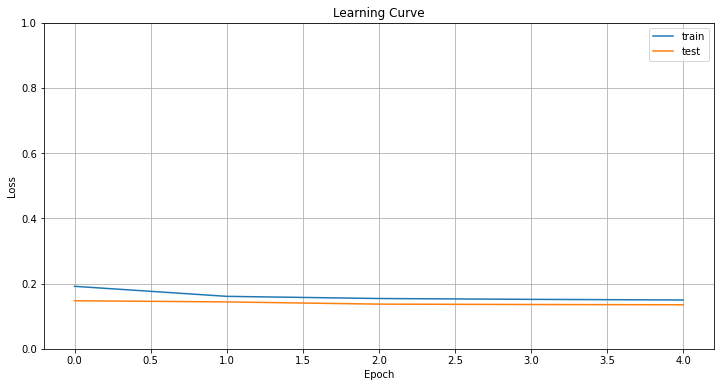

In [13]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

# ResNest50

## Use ResNet to do image classification by specifying a learning rate and decay rate.

In [30]:
optimizer = Adam(0.003, decay=0.0005)
base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = True
    

model = Sequential([
    base_model,
    
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
    
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_22 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 17)                2193      
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val))

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 423s 13ms/step - loss: 0.3031 - fbeta_score_K: 0.5927 - val_loss: 1.6526 - val_fbeta_score_K: 0.4325
Epoch 2/5
32383/32383 [==============================] - 298s 9ms/step - loss: 0.2266 - fbeta_score_K: 0.6349 - val_loss: 0.2702 - val_fbeta_score_K: 0.6506
Epoch 3/5
32383/32383 [==============================] - 298s 9ms/step - loss: 0.1960 - fbeta_score_K: 0.6718 - val_loss: 0.2745 - val_fbeta_score_K: 0.6040
Epoch 4/5
32383/32383 [==============================] - 298s 9ms/step - loss: 0.1690 - fbeta_score_K: 0.7136 - val_loss: 0.1858 - val_fbeta_score_K: 0.6694
Epoch 5/5
32383/32383 [==============================] - 298s 9ms/step - loss: 0.1609 - fbeta_score_K: 0.7280 - val_loss: 0.2816 - val_fbeta_score_K: 0.7122


In [32]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

F beta score:  0.7773114897160325
Error: 22.27%


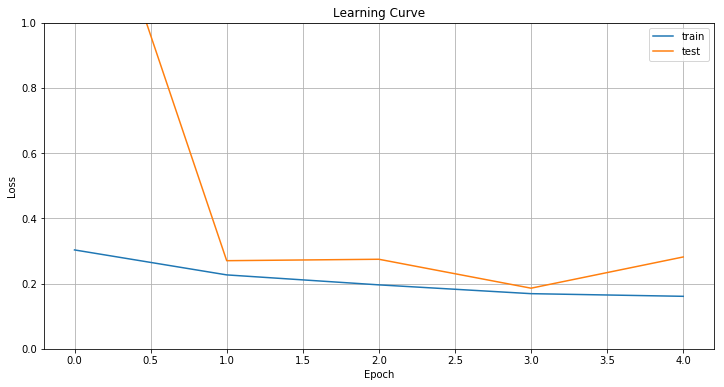

In [33]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

## Lower the learning and decay rate to see if model performance improves.

In [34]:
optimizer = Adam(0.0001, decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val))

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
32383/32383 [==============================] - 315s 10ms/step - loss: 0.1457 - fbeta_score_K: 0.7474 - val_loss: 0.1567 - val_fbeta_score_K: 0.7527
Epoch 2/5
32383/32383 [==============================] - 300s 9ms/step - loss: 0.1429 - fbeta_score_K: 0.7541 - val_loss: 0.1384 - val_fbeta_score_K: 0.7545
Epoch 3/5
32383/32383 [==============================] - 299s 9ms/step - loss: 0.1390 - fbeta_score_K: 0.7607 - val_loss: 0.1363 - val_fbeta_score_K: 0.7680
Epoch 4/5
32383/32383 [==============================] - 299s 9ms/step - loss: 0.1363 - fbeta_score_K: 0.7652 - val_loss: 0.1600 - val_fbeta_score_K: 0.7562
Epoch 5/5
32383/32383 [==============================] - 299s 9ms/step - loss: 0.1401 - fbeta_score_K: 0.7602 - val_loss: 0.1520 - val_fbeta_score_K: 0.7155


In [35]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("F beta score: ", score)
print("Error: %.2f%%" % (100-score*100))

F beta score:  0.8600877727334871
Error: 13.99%


## The performance improved as compared to previous trained ResNet model.

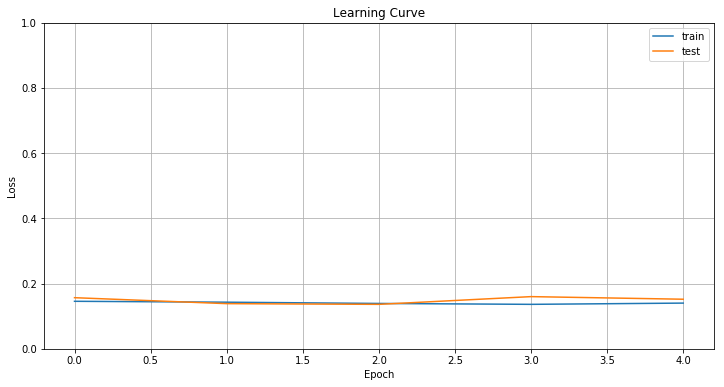

In [36]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

## Unfreezing all layers of ResNet to retrain them from scratch instead of using the pre-trained weights.

In [37]:
for layer in model.layers[0].layers[1:]:
    layer.trainable = True

for layer in model.layers[0].layers:
    print(layer.name, layer.trainable)

model.summary()

input_3 True
conv1_pad True
conv1 True
bn_conv1 True
activation_50 True
pool1_pad True
max_pooling2d_6 True
res2a_branch2a True
bn2a_branch2a True
activation_51 True
res2a_branch2b True
bn2a_branch2b True
activation_52 True
res2a_branch2c True
res2a_branch1 True
bn2a_branch2c True
bn2a_branch1 True
add_17 True
activation_53 True
res2b_branch2a True
bn2b_branch2a True
activation_54 True
res2b_branch2b True
bn2b_branch2b True
activation_55 True
res2b_branch2c True
bn2b_branch2c True
add_18 True
activation_56 True
res2c_branch2a True
bn2c_branch2a True
activation_57 True
res2c_branch2b True
bn2c_branch2b True
activation_58 True
res2c_branch2c True
bn2c_branch2c True
add_19 True
activation_59 True
res3a_branch2a True
bn3a_branch2a True
activation_60 True
res3a_branch2b True
bn3a_branch2b True
activation_61 True
res3a_branch2c True
res3a_branch1 True
bn3a_branch2c True
bn3a_branch1 True
add_20 True
activation_62 True
res3b_branch2a True
bn3b_branch2a True
activation_63 True
res3b_branch2b T

In [40]:
model_fit = model.fit(
    X, y,
    batch_size=128,
    epochs=3,
    verbose=1,
    validation_data=(X_val, y_val))

Train on 40479 samples, validate on 8096 samples
Epoch 1/3
40479/40479 [==============================] - 374s 9ms/step - loss: 0.1368 - fbeta_score_K: 0.7665 - val_loss: 0.1350 - val_fbeta_score_K: 0.7795
Epoch 2/3
40479/40479 [==============================] - 369s 9ms/step - loss: 0.1338 - fbeta_score_K: 0.7723 - val_loss: 0.1313 - val_fbeta_score_K: 0.7797
Epoch 3/3
40479/40479 [==============================] - 369s 9ms/step - loss: 0.1331 - fbeta_score_K: 0.7740 - val_loss: 0.1748 - val_fbeta_score_K: 0.7675


In [41]:
y_pred = model.predict(X_val, batch_size=128)
score = fbeta_score(y_val, np.array(y_pred) > 0.2, beta=2, average='samples')

print("Test score (f1): ", score)
print("Error: %.2f%%" % (100-score*100))

Test score (f1):  0.83533792262086
Error: 16.47%


## Model performance deteriorates as compared to ResNet model used with pre-trained weights.

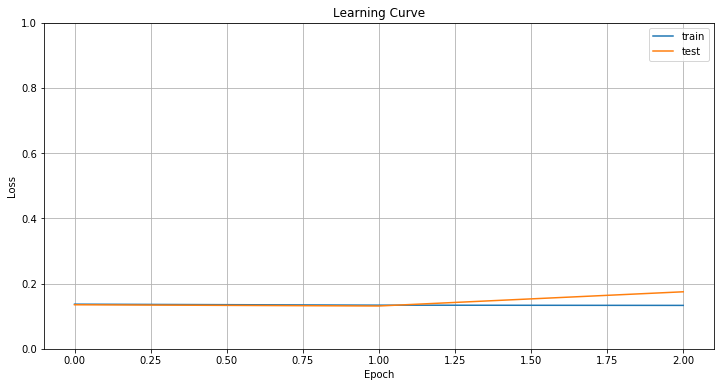

In [42]:
learning_curve(model_fit, key='loss', ylim=(0, 1))

# In this case VGG with ImageGenerator worked the best.

In [14]:
# Generating a csv file for submisison to Kaggle.
X_test = []
submission = []
for file in listdir('C:/Users/4769939/Downloads/archive/planet/planet/test-jpg'):
    filename = file.split('.')[0]
    
    img = cv2.imread('C:/Users/4769939/Downloads/archive/planet/planet/test-jpg/{}.jpg'.format(filename))
    targets = np.zeros(17)
    
    X_test.append(cv2.resize(img, (128, 128)))
    submission.append(filename)

X_test = np.array(X_test, np.float16) / 255

y_test = model.predict(X_test, batch_size=128)

with open('understanding_the_amazon_from_space.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(('image_name', 'tags'))
    for i, image in enumerate(submission):
        csv_writer.writerow((image, ' '.join(np.array(labels)[y_test[i] > 0.2])))

479/479 [==============================] - 2730s 6s/step
